#Residual Analysis in Regressions
By Chris Fenaroli and Max Margenot 

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---
Linear regression is a technique that models the relationship between an independent variable $X$ and a dependent outcome variable $Y$. Simple linear regression with two variables allows us to determine which linear model of the form $Y = \beta_0 + \beta_1 X$ best explains the data. 

A multiple linear regression model generalizes linear regression, allowing for the dependent variable to be a linear function of multiple independent variables. Now instead of just being a function of $X$, $Y$ is a linear function of $X_1,\ldots, X_k$:

$$ Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_k X_k + \epsilon_i $$

More background information on regressions can be found in the [simple linear regression](https://www.quantopian.com/lectures#Linear-Regression) and [multiple linear regression lectures.](https://www.quantopian.com/lectures#Multiple-Linear-Regression)





Despite a linear regression yielding the best possible linear model, almost never is the model perfectly accurate. Instead, there are usually gaps between what a model predicts and what can be observed in the sample. These gaps are known as residuals and can be used to check for some of the basic assumptions of the linear model, including:

* **Linear Fit:** The underlying relationship should be linear
* **Homoscedastic:** The data should have a constant variance
* **Independent and Identically Distributed:** The residuals of the regression should be independent and identically distributed (i.i.d.) and show no signs of serial correlation

Statistical error is a similar metric associated with regression analysis with one important difference: While residuals quantify the gap between a regression model and the sample, statistical error is the difference between a regression model and the underlying relationship. This means statsitical errors are usually unknown.

In [24]:
# Import libraries
import numpy as np
import pandas as pd
from statsmodels import regression
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

First we'll define a function that performs linear regression and plots the results.

In [25]:
def linreg(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    B0 = model.params[0]
    B1 = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * B1 + B0
    plt.scatter(X, Y, alpha=1) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=1);  # Add the regression line, colored in red
    plt.xlabel('X Value', fontsize = 20)
    plt.ylabel('Y Value', fontsize = 20)
    return model, B0, B1

Let's run a linear regression (using the `linreg` function defined above) on the following variables $X$ and $Y$. 

$X$ is our independent variable, and $Y$ is our dependent, or outcome, variable. The relationship between $X$ and $Y$ will serve as our toy example as we explore residual analysis. We have defined their relationship as $$Y = 10 + \frac{1}{2}X + \epsilon$$

Line of best fit: Y = B0 + B1*X
B0 =  9.65366969308
B1 =  0.515962511758


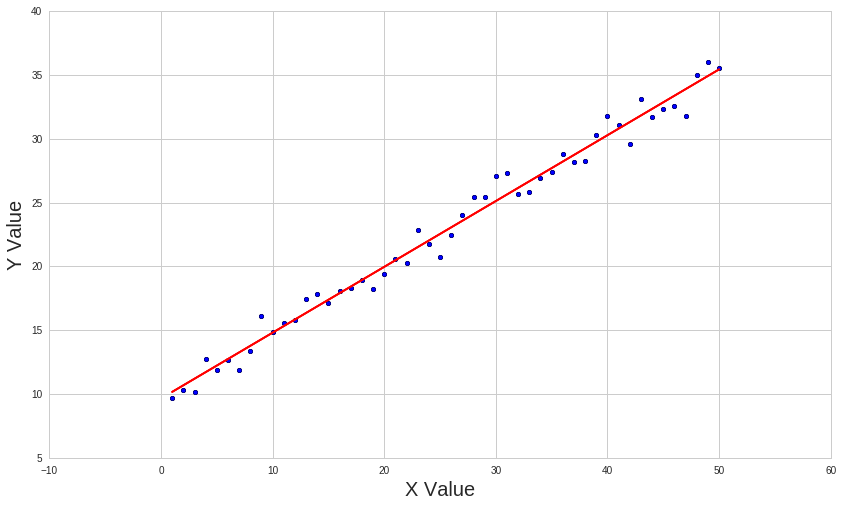

In [52]:
n = 50
X = np.linspace(1, n, n)

# NOTE: Epsilon simulates the randomness of sampling and is
# not a part of the underlying relationship between X and Y
epsilon = np.random.normal(0, 1, n)
Y = 10 + (0.5) * X + epsilon

linreg(X,Y)[0];
print "Line of best fit: Y = B0 + B1*X"
print "B0 = ", linreg(X,Y)[1]
print "B1 = ", linreg(X,Y)[2]

The red line was produced by `linreg` as the linear function of the form 

$$\hat{Y} = \hat{\beta_0} + \hat{\beta_1}X$$

that best fits the data, where $\hat{Y}$ is the predicted Y-value and $\hat{\beta_0}$ and $\hat{\beta_1}$ are the regression coefficients.  The blue points represent the sample data that was used to calibrate the regression line. If the model was flawless and was a perfect explanation of the sample, all the blue points would lie exactly on the red line. However, a linear regression is only an approximation, and due to the noise from the randomness of the sample a vast majority lie off of the regression line. This means that for almost all values of $X$ there is a difference between what the regression predicted and what is actually observed.

##What are Residuals?

For a given X-value, the residual is the difference between what is observed in the sample and what is predicted by the regression. A small residual means the regression predicted a Y-value that was close to what was observed, while a large residual means the regression predicted a Y-value far off from what was in the sample.

The formula for residual $r$ is: $$r = Y - \hat{Y}$$

Where $Y$ is the observed Y-value and $\hat{Y}$ is the predicted Y-value.

To visualize residuals, let's show them as a green line on the graph from above, where the magnitude of each green line is equivalent to the magnitude of the residual for the given X-value:

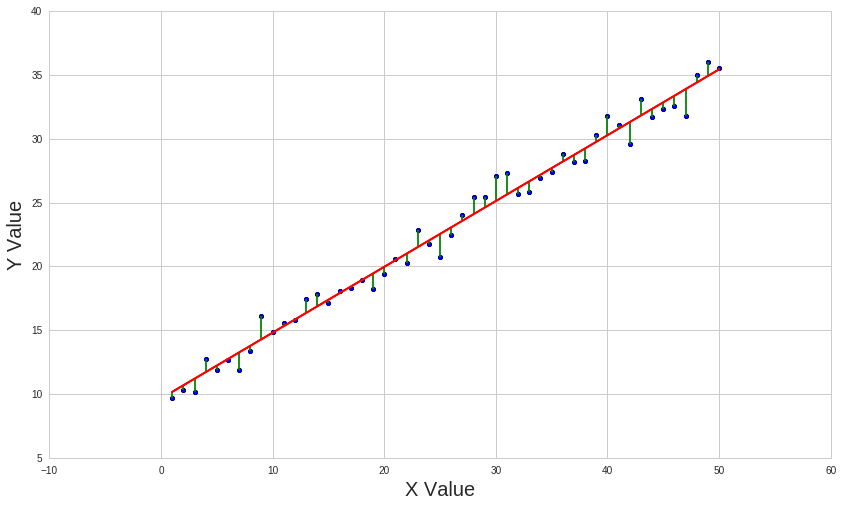

In [53]:
B0 = linreg(X,Y)[1]
B1 = linreg(X,Y)[2]

linreg(X,Y)[0];

yerr = Y - B1*X - B0
plt.errorbar(X,Y,xerr=0,yerr=[yerr,0*yerr],linestyle="None",color='Green');

Because the regression line is a linear approximation, we see that the blue dots representing the sample data do not lie directly on the line. Residuals, represented by the green lines, quantify the extent to which the approximation differs from the observed sample for a given X-value.

##Calculating Residuals

When dealing with residuals, you rarely look at only one or two. Rather, a residual are most valueable in the context of all of the residuals for a particular regression model and sample. Let's find all of the residuals, using the `statsmodels` method `resid`, and put them in a Pandas dataframe.

In [28]:
X = sm.add_constant(X)

# Finding residuals using the .resid method
residuals = [regression.linear_model.OLS(Y, X).fit().resid]

df = pd.DataFrame(residuals, index = ["Residuals"])
X = X[:,1]
df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Residuals,1.146508,1.523444,-2.656186,0.679157,-2.126881,0.064699,-0.110794,0.694143,1.379151,0.991057,...,1.123868,-0.92612,0.517263,0.002837,1.529367,0.157547,-0.192407,-0.247425,-1.257716,1.160771


##Error vs. Residual
Statistical error is another metric associated with regression analysis. These two concepts can seem similar but have a couple key differences:
* Statistical error is the difference between the regression estimate and the population expected value, while residual error is the difference between the regression estimate and the observed sample value
* Residuals are observable values, while statistical error is unobservable as long as the population parameters are unknown

The formula for statistical error is : $$\epsilon = \mu -  \hat{Y}$$

Where $\mu$ is the population mean Y-value and $\hat{Y}$ is the Y-value predicted by the regression.

Using the above formula, let's find statistical errors for all of X in the regression from before and add it to our dataframe.

In [29]:
mu = 10 + 0.5*X
df.loc['Error'] = mu - Y_hat
df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Residuals,1.146508,1.523444,-2.656186,0.679157,-2.126881,0.064699,-0.110794,0.694143,1.379151,0.991057,...,1.123868,-0.926120,0.517263,0.002837,1.529367,0.157547,-0.192407,-0.247425,-1.257716,1.160771
Error,0.269782,0.252580,0.235378,0.218176,0.200974,0.183773,0.166571,0.149369,0.132167,0.114965,...,-0.418293,-0.435495,-0.452697,-0.469899,-0.487101,-0.504302,-0.521504,-0.538706,-0.555908,-0.573110


#Why are Residuals Important?
###Residuals can tell us valuable details about the validity of our model.

The validity of a linear regression model depends on whether or not the underlying data satisfies certain assumptions. Some key assumptions are:

* **Linear Fit:** The underlying relationship should be linear
* **Homoscedastic:** The data should have a constant variance
* **Independent and Identically Distributed:** The residuals of the regression should be independent and identically distributed (i.i.d.) and show no signs of autocorrelation

Many of these details can be identify through patterns in the residuals. To see these patterns it is useful to visualize the residuals, so the first method for residual analysis we will cover is residual plots, a residual visualization tool.

##Residual Plots

A residual plot is a graph with residual values on the y-axis and the independent variable on the x-axis. Being able to visualize all the residuals for a model is a valuable tool, with utility in detecting linear fit, heteroscedasticity (non-constant variance), and autocorrelation.

Let's take our example regression and plot its residuals:

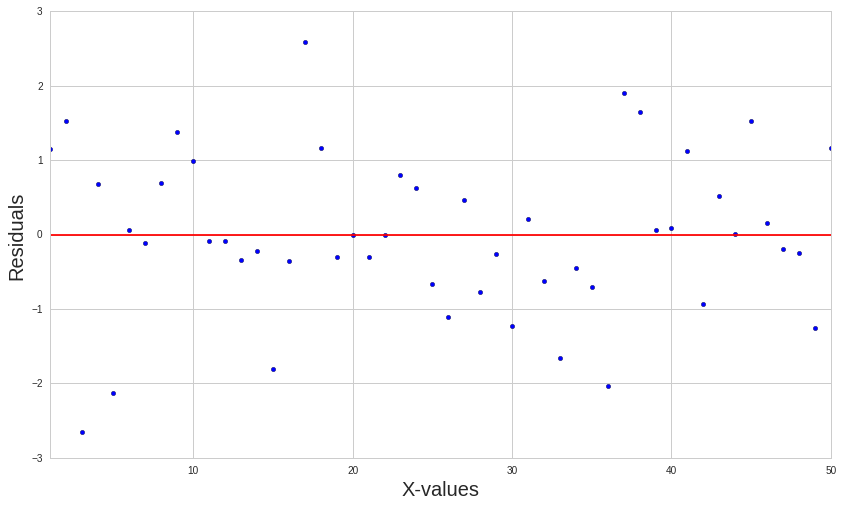

In [30]:
plt.scatter(X, df.loc['Residuals']);
plt.plot(X, X*0, color = 'Red');
plt.xlabel('X-values', fontsize = 20);
plt.ylabel('Residuals', fontsize = 20);
plt.xlim([1,50]);

One important thing to note is the fairly random distribution of residuals; the blue dots form no discernible pattern. This means that a linear model is likely a good fit and that there no data anomalies such as autocorrelation or heteroscedasticity  affecting our results.

##Appropriateness of a Linear Model

By looking for patterns in residual plots we can determine whether the underlying relationship is appropriate for a linear model. An underlying relationship is appropriate for a linear model if the relationship is linear itself, such as our toy example of $Y = 10 + \frac{1}{2} X$. An underlying relationship of the form $Y = \beta_0 + \beta_1 X^2$, for example, would not be appropriate for linear regression as a linear function would not be able to fully explain the relationship between $X$ and $Y$.

If the relationship is not a good fit for a linear model, the residual plot will show a distinct pattern, such as a "U" or "inverted-U" shape. In general, a residual plot of a linear regression on a non-linear relationship will show "bias" and be asymmetrical with respect to residual = 0 line while a residual plot of a linear regression on a linear relationship will be generally symmetrical over the residual = 0 axis.

As an example, let's consider a new relationship between the variables $X$ and $Y$:

$$Y = 10 - X^{1.2} + \epsilon$$ 

By regressing $X$ and $Y$, plotting their residuals, and looking for a pattern we can determine whether a linear model is an appropriate fit.

16.3058050006 -2.24065996455


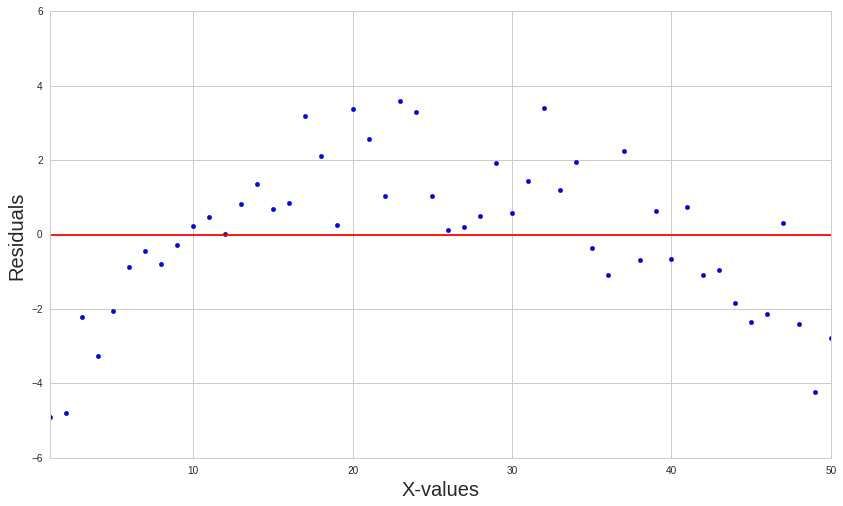

In [78]:
epsilon = np.random.normal(0, 1, n)
Y_nonlinear = 10 - X**1.2 + epsilon

# Regressing X and Y_nonlinear
X1 = sm.add_constant(X)
model = regression.linear_model.OLS(Y_nonlinear, X1).fit()

# Coefficients produced by regression
B0 = model.params[0]
B1 = model.params[1]

# Calculating residual using coefficients
Y_nonlinear_hat = (B1*X + B0)
residuals = Y_nonlinear - Y_nonlinear_hat

print B0,B1
plt.scatter(X, residuals);
plt.plot(X, X*0, color = 'Red');
plt.xlabel('X-values', fontsize = 20)
plt.ylabel('Residuals', fontsize = 20)
plt.xlim([1,50]);

The "inverted-U" shape shown by the residuals is a sign that a non-linear model might be a better fit than a linear one. Next steps would be to adopt a non-linear model which best fits the data.

##Residuals and Non-Constant Variance (Heteroscedasticity)

One of the main assumptions behind a linear regression is that the underlying data has a constant variance. If there are some parts of the data with a variance different from another part the data is not appropriate for a linear regression. Heteroscedastic is a term describing data with non-constant variance while homoscedastic describes data with constant variance.

Significant heteroscedasticity invalidates linear regression results because although it does not introduce any bias to the regression estimates (meaning the residual plot will remain generally symmetrical with respect to the residual = 0 line), standard errors associated with the regression will be biased. Standard error is a statistic vital to many associated inference methods, such as significance tests and confidence intervals. 

To avoid these consequences it is important to use residual plots to check for heteroscedasticity and adjust if necessary.

As an example of detecting and correcting heteroscedasticity, let's consider a relationship between $X$ and $Y$:

$$Y = 5 + \frac{1}{2}X + \epsilon X$$



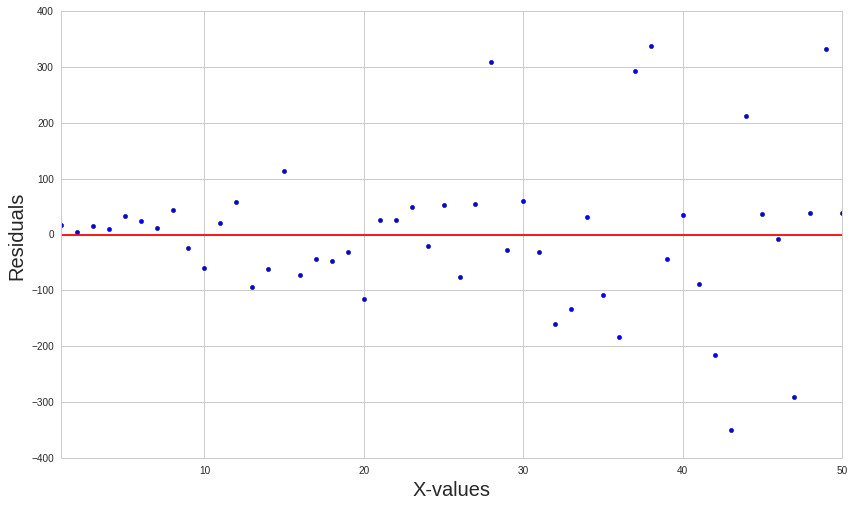

In [146]:
epsilon = np.random.poisson(15, n)
Y_heteroscedastic = 5 + 0.5*X + epsilon*X

# Regressing X and Y_heteroscedastic
X1 = sm.add_constant(X)
model = regression.linear_model.OLS(Y_heteroscedastic, X1).fit()

# Coefficients produced by regression
B0 = model.params[0]
B1 = model.params[1]

# Calculating residual using coefficients
Y_heteroscedastic_hat = (B1*X + B0)
residuals = Y_heteroscedastic - Y_heteroscedastic_hat

plt.scatter(X, residuals);
plt.plot(X, X*0, color = 'Red');
plt.xlabel('X-values', fontsize = 20)
plt.ylabel('Residuals', fontsize = 20)
plt.xlim([1, 50]);

Using a residual plot, heteroscedasticity becomes apparent. As we move along in the positive-X direction the magnitudes of the residuals are clearly increasing. A linear regression is unable to explain this varying variability and the regression standard errors will be biased.

###Statistical Methods for Detecting Heteroscedasticity
It can be useful to back up qualitative observations on a residual plot with a quantitative method. The residual plot led us to believe that the data might be heteroscedastic. Let's confirm that result with a statistical test.

A Breusch-Pagan test is used to test for heteroscedasticity in a linear regression model. The Breusch-Pagan test works by considering residual variance as linearly related to the independent variable $X$. It runs a linear regression on residual variance and the independent variable and examines the strength of the their possible linear relationship. One shortcoming of the Breusch-Pagan test is that it assumes variance to be a linear function of the independent variable and is not as effective at detecting non-linear heteroscedasticity. As a result it is always best to combine your Breusch-Pagan test result with qualitative results from the residual plot, or combine it with other heteroscedasticity tests such as the White test.

Let's use the Breusch-Pagan to test for heteroscedasticity in our relationship from above. A function exists in the `statsmodels` package called `het_breushpagan` that simplifies the computation:

In [147]:
# Running and interpreting a Breusch-Pagan test

bp_before = smd.het_breushpagan(model.resid, model.model.exog)[1]

print bp_before
if bp_before > 0.05:
    print "The relationship is not heteroscedastic."
if bp_before < 0.05:
    print "The relationship is heteroscedastic."

0.000921903250723
The relationship is heteroscedastic.


The Breusch-Pagan p-value below 0.05 tells us that the relationship is heteroscedastic. For more on hypothesis tests and interpreting p-values, refer to the [lecture on hypothesis testing.](https://www.quantopian.com/research/notebooks/Cloned%20from%20%22Quantopian%20Lecture%20Series%3A%20Hypothesis%20Testing%22%201.ipynb)

*Note: We can clearly see that the underlying relationship $Y = 5 + \frac{1}{2}X + \epsilon X$ is heteroscedastic, however due to testing error and the randomness of the example occasionally the test will result in a false rejection of the alternative hypothesis (type II error). This applies for all hypothesis tests, including tests in the remainder of the lecture.*

##Adjusting for Heteroscedasticity

If after creating a residual plot and conducting Breusch-Pagan and White tests you believe your data is heteroscedastic, there are a number of methods you can use to attempt to adjust for it. The three we will focus on are differences analyses, logarithmic transformations, and Box-Cox transformations.

###Differences Analysis
First, let's examine differences analysis, which involves looking at the first-order differences between adjacent values. These values are more likely to be homoscedastic. If the differences transformation is successful in achieving homoscedasticity, we can then conduct the regression on the differences instead.

Let's attempt to correct for heteroscedasticity between $X$ and $Y$ using a differences analysis:

In [154]:
# Finding first-order differences in Y_heteroscedastic
Y_heteroscedastic_diff = np.append(0, np.diff(Y_heteroscedastic))

Now that we have stored the first-order differences of `Y_heteroscedastic` in `Y_heteroscedastic_diff` let's repeat the regression and residual plot to see if the heteroscedasticity is still present:

0.000875723308297
The relationship is heteroscedastic.


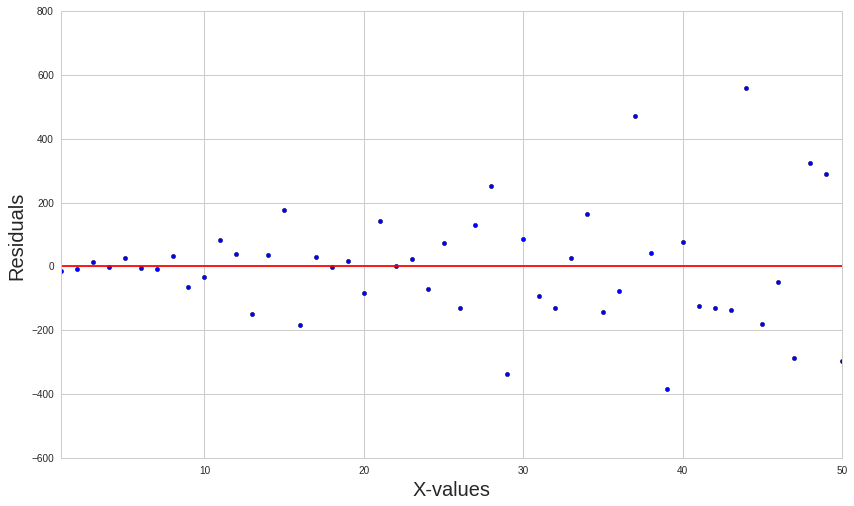

In [155]:
X1 = sm.add_constant(X)
model2 = regression.linear_model.OLS(Y_heteroscedastic_diff, X1).fit()

# Coefficients produced by regression
B0 = model2.params[0]
B1 = model2.params[1]

# Calculating residual using coefficients
Y_heteroscedastic_diff_hat = (B1*X + B0)
residuals = Y_heteroscedastic_diff - Y_heteroscedastic_diff_hat

plt.scatter(X, residuals);
plt.plot(X, X*0, color = 'Red');
plt.xlabel('X-values', fontsize = 20)
plt.ylabel('Residuals', fontsize = 20)
plt.xlim([1, 50]);

# Running and interpreting a Breusch-Pagan test
bp_after = smd.het_breushpagan(model2.resid, model2.model.exog)[1]
print bp_after
if bp_after > 0.05:
    print "The relationship is not heteroscedastic."
if bp_after < 0.05:
    print "The relationship is heteroscedastic."

Because the Breusch-Pagan test yielded a p-value below 0.05, we can conclude that the relationship is still heteroscedastic after the differences transformation.

*Note: This new regression was conducted on the differences between data, and therefore the regression output must be back-transformed to reach a prediction in the original scale. Since we regressed the differences, we can add our predicted difference onto the original data to get our estimate:*

$$\hat{Y_i} = Y_{i-1} + \hat{Y_{diff}}$$

### Logarithmic Transformation

Let's look next at apply a log transformation to the underlying data. A log transformation will bring residuals closer together and thus make the data more homoscedastic. In many (though not all) cases, a log transformation is sufficient  in stabilizing the variance of a relationship.

Let's try a log transformation on the heteroscedastic relationship between $X$ and $Y$.

In [162]:
# Taking the log10 of the previous data Y_heteroscedastic and saving it in Y_heteroscedastic_log
Y_heteroscedastic_log = np.log10(Y_heteroscedastic)

Now that we have stored the log transformed version of `Y_heteroscedastic` in `Y_heteroscedastic_log` let's repeat the regression and residual plot to see if the heteroscedasticity is still present:

0.0669876499086
The relationship is not heteroscedastic.


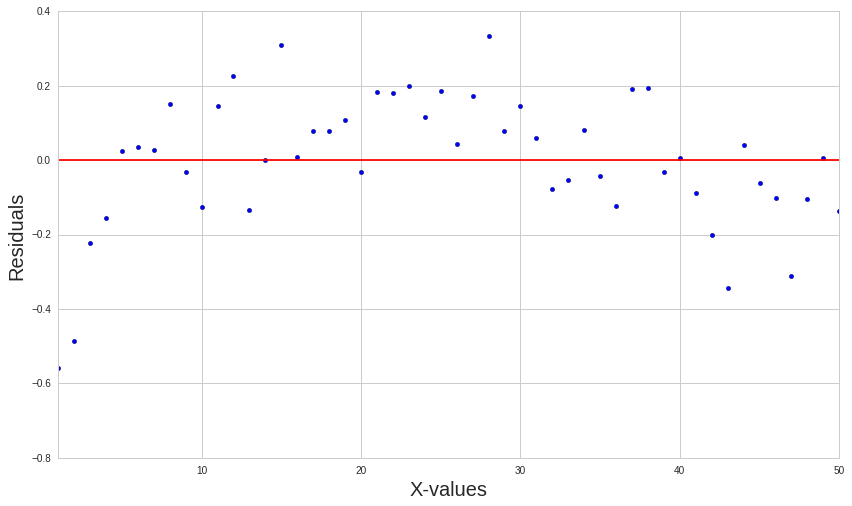

In [157]:
X1 = sm.add_constant(X)
model3 = regression.linear_model.OLS(Y_heteroscedastic_log, X1).fit()

# Coefficients produced by regression
B0 = model3.params[0]
B1 = model3.params[1]

# Calculating residual using coefficients
Y_heteroscedastic_log_hat = (B1*X + B0)
residuals = Y_heteroscedastic_log - Y_heteroscedastic_log_hat

plt.scatter(X, residuals);
plt.plot(X, X*0, color = 'Red');
plt.xlabel('X-values', fontsize = 20)
plt.ylabel('Residuals', fontsize = 20)
plt.xlim([1, 50]);

# Running and interpreting a Breusch-Pagan test
bp_after = smd.het_breushpagan(model3.resid, model3.model.exog)[1]
print bp_after
if bp_after > 0.05:
    print "The relationship is not heteroscedastic."
if bp_after < 0.05:
    print "The relationship is heteroscedastic."

*Note: This new regression was conducted on the log of the original data. This means the scale has been altered and the regression estimates will lie on this transformed scale. To bring the estimates back to the original scale, you must back-transform the values using the inverse of the log:*

$$\hat{Y} = 10^{Y_{log}}$$

###Box-Cox Transformation
The last of the methods we will examine is the Box-Cox transformation. The Box-Cox power transformation is a powerful method that will work on many types of heteroscedastic relationships. The process works by testing all values of $\lambda$ within the range $[-5, 5]$ to see which makes the output of the following equation closest to being normally distributed:

$$
Y'\left(\lambda, Y\right) = \left\{
     \begin{array}{lr}
       \frac{Y^{\lambda}-1}{\lambda} & : \lambda \neq 0\\
       \log{Y} & : \lambda = 0
     \end{array}
   \right.\\
$$

The "best" $\lambda$ will be used to transform the series along the above function.

Instead of having to do all of this manually, we can use the `scipy` function `boxcox`. Let's use this function to adjust $Y$ so that a linear model is more appropriate.

*Note: The Box-Cox transformation can only be used if all the data is positive* 

In [158]:
# Finding a power transformation adjusted Y_heteroscedastic
Y_heteroscedastic_prime = stats.boxcox(Y_heteroscedastic)[0]

Now that we have stored the power transformed version of `Y_heteroscedastic` in `Y_heteroscedastic_prime` let's repeat the regression and residual plot to see if the heteroscedasticity is still present:

0.0517992059841
The relationship is not heteroscedastic.


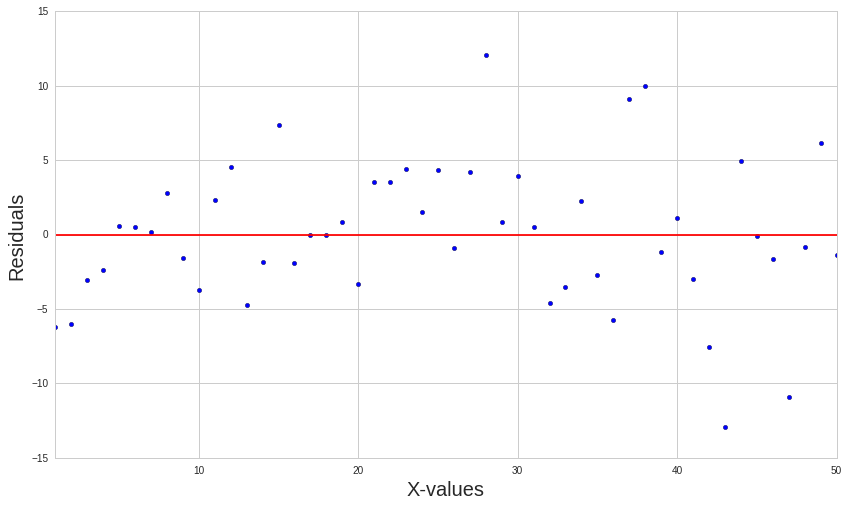

In [159]:
X1 = sm.add_constant(X)
model2 = regression.linear_model.OLS(Y_heteroscedastic_prime, X1).fit()

# Coefficients produced by regression
B0 = model2.params[0]
B1 = model2.params[1]

# Calculating residual using coefficients
Y_heteroscedastic_prime_hat = (B1*X + B0)
residuals = Y_heteroscedastic_prime - Y_heteroscedastic_prime_hat

plt.scatter(X, residuals);
plt.plot(X, X*0, color = 'Red');
plt.xlabel('X-values', fontsize = 20)
plt.ylabel('Residuals', fontsize = 20)
plt.xlim([1, 50]);

# Running and interpreting a Breusch-Pagan test
bp_after = smd.het_breushpagan(model2.resid, model2.model.exog)[1]
print bp_after
if bp_after > 0.05:
    print "The relationship is not heteroscedastic."
if bp_after < 0.05:
    print "The relationship is heteroscedastic."

Because the Breusch-Pagan test yielded a p-value above 0.05, we can conclude that the relationship is no longer heteroscedastic after the Box-Cox transformation and the uniform random distribution of the residual plot confirms our result from the Breusch-Pagan test. 

*Note: Now that the relationship is not heteroscedastic, a linear regression is appropriate. However, because the data was power transformed, the regression estimates will be on a different scale than the original data. This is why it is important to remember to back-transform results using the inverse of the Box-Cox function:*

$$\hat{Y} = (Y'\lambda + 1)^{1/\lambda}$$


###GARCH Modeling

Another approach to dealing with heteroscadasticity is GARCH (generalized autoregressive conditional heteroscedasticity) modeling, which unlike homoscedastic models accomodates changing volatility. More information can be found in the [GARCH modeling lecture.](https://www.quantopian.com/lectures#ARCH,-GARCH,-and-GMM)



##Residuals and Autocorrelation

Another assumption behind linear regressions is that the underlying data is not autocorrelated. A series is autocorrelated if the next term in the series is somehow correlated with other terms of the same series on a certain interval. An example of an autocorrelated series would be daily high temperatures, as seeing today's temperature gives you information on tomorrow's (i.e. if it is 90 °F today, you can be very confident that it will not be below freezing tomorrow). A series of fair dice rolls, however, would not be autocorrelated as seeing one roll gives you no information on what the next might be. The value of the rolls are independent.

In finance, stock prices are usually autocorrelated while stock returns are independent from one another.

As an example, let's consider a final relationship between variables $X$ and $Y$, where $Y$ is a time series where each term is equivalent to the previous term plus some random noise:

$$Y_i = Y_{i-1} + \epsilon$$

If the underlying data is autocorrelated, given a residual you will be able to make predictions about adjacent residuals. In the case of $A$, we know the data is autocorrelated because we can make predictions based on adjacent residuals being close to one another.

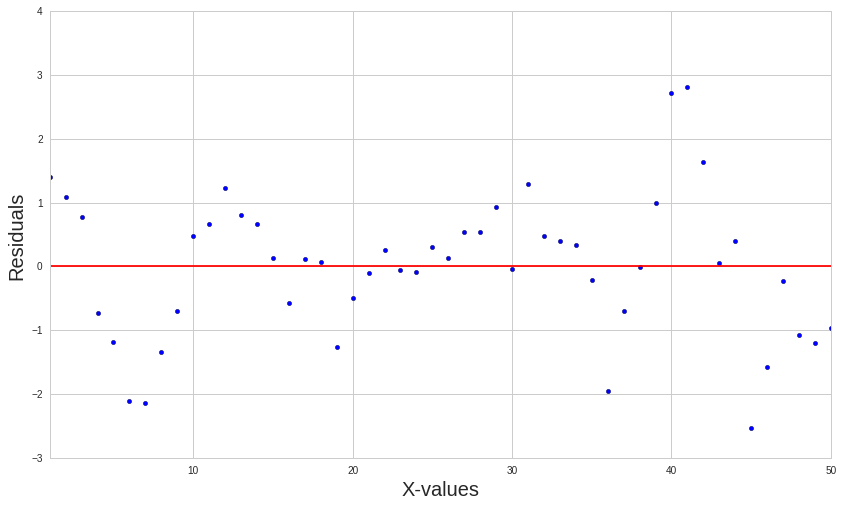

In [160]:
Y_autocorrelated = np.zeros(n)
for t in range(1, n):
    epsilon = np.random.normal(0, 1)
    Y_autocorrelated[t] = Y_autocorrelated[t-1] + epsilon 

# Regressing X and Y_autocorrelated
X1 = sm.add_constant(X)
model = regression.linear_model.OLS(Y_autocorrelated, X1).fit()

# Coefficients produced by regression
B0 = model.params[0]
B1 = model.params[1]

# Calculating residual using coefficients
Y_autocorrelated_hat = (B1*X + B0)
residuals = Y_autocorrelated - Y_autocorrelated_hat

plt.scatter(X, residuals);
plt.plot(X, X*0, color = 'Red');
plt.xlabel('X-values', fontsize = 20)
plt.ylabel('Residuals', fontsize = 20)
plt.xlim([1,50]);

The above residuals shows signs of autocorrelation as one residual can be used to make predictions about another. Here we see that no two adjacent residuals have significant differences in magnitude, meaning they are not independent and given one residual we can gain information about adjacent ones.

###Statistical Methods for Detecting Autocorrelation
Similar to testing for heteroscedasticity, it can be useful to reaffirm qualitative observations with quantitative tests.

A Ljung-Box test is used to detect autocorrelation in the underlying data of a linear regression model. The Ljung-Box test examines autocorrelation at all lag intervals below a specified maximum and returns arrays containing the outputs for every tested lag interval. A function exists in the statsmodels package called `acorr_ljungbox` that simplifies the test's computation. 

Let's use the `acorr_ljungbox` function to test for autocorrelation of the above relationship between $X$ and $Y$. We'll use a max lag interval of 5, and see if any of the lags have significant autocorrelation:

In [161]:
lb = smd.acorr_ljungbox(Y_autocorrelated, lags = 5)
print "Lagrange Multiplier Statistics:", lb[0]
print "\nP-values:", lb[1], "\n"

if all(lb[1] > 0.05):
    print "The relationship is not autocorrelated."
if any(lb[1] < 0.05):
    print "The relationship is autocorrelated."

Lagrange Multiplier Statistics: [ 36.48020855  60.17682767  73.83028297  81.64394796  85.95008739]

P-values: [  1.54224285e-09   8.56579946e-14   6.45330687e-16   7.80991824e-17
   4.75808808e-17] 

The relationship is autocorrelated.


Because the Ljung-Box test yielded a p-value below 0.05 for at least one lag interval, we can conclude that the relationship is autocorrelated.

##Adjusting for Autocorrelation

An easy way to attempt to adjust for autocorrelation is through looking at the first-order differences of the data set. Despite an autocorrelated series having data points that are not independent, sometimes the differences between those terms are. 

Let's see if the first-order differences of $Y$ are autocorrelated:

In [47]:
# Finding first-order differences in Y_autocorrelated
Y_autocorrelated_diff = np.append(0, np.diff(Y_autocorrelated))

P-values: [ 0.91454587  0.04521643  0.06871702  0.12929336  0.15285348] 

The relationship is autocorrelated.


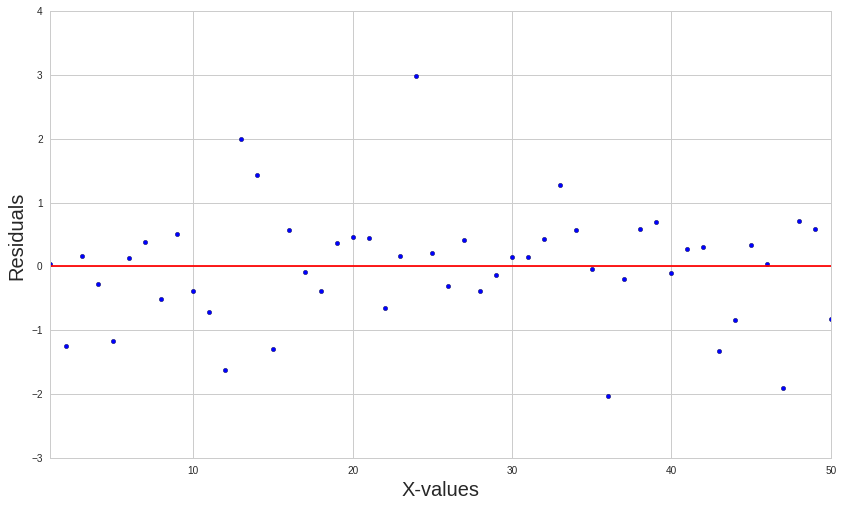

In [68]:
X1 = sm.add_constant(X)
model5 = regression.linear_model.OLS(Y_autocorrelated_diff, X1).fit()

# Coefficients produced by regression
B0 = model5.params[0]
B1 = model5.params[1]

# Calculating residual using coefficients
Y_autocorrelated_diff_hat = (B1*X + B0)
residuals = Y_autocorrelated_diff - Y_autocorrelated_diff_hat

plt.scatter(X, residuals);
plt.plot(X, X*0, color = 'Red');
plt.xlabel('X-values', fontsize = 20)
plt.ylabel('Residuals', fontsize = 20)
plt.xlim([1, 50]);

# Running and interpreting a Ljung-Box test
lb = smd.acorr_ljungbox(Y_autocorrelated_diff, lags = 5)
print "P-values:", lb[1], "\n"

if all(lb[1] > 0.05):
    print "The relationship is not autocorrelated."
if any(lb[1] < 0.05):
    print "The relationship is autocorrelated."

Because the Ljung-Box test yielded a p-value below 0.05 for at least one lag interval, we can conclude that the relationship is autocorrelated.

*Note: This new regression was conducted on the differences between data, and therefore the regression output must be back-transformed to reach a prediction in the original scale. Since we regressed the differences, we can add our predicted difference onto the original data to get our estimate:*

$$\hat{Y_i} = Y_{i-1} + \hat{Y_{diff}}$$

###Autoregressive Models
Another method for adjusting for autocorrelation of residuals involves changing the model to one that factors in autocorrelation. One model you can use is an autoregressive (AR) model. More information can be found in the [lecture on AR models](https://www.quantopian.com/lectures#Autocorrelation-and-AR-Models) and [Wikipedia page on AR models.](https://en.wikipedia.org/wiki/Autoregressive_model)

##Mean Squared Error

An important use of residuals, besides diagnosing linear model violations, is calculation mean squared error. In regression analysis, mean squared error is the sum of all the residuals squared, divided by the degress of freedom. The formula is:

$$MSE = \frac{\sum_{i=1}^{n} (Y_i - \hat{Y_i})^2}{df}$$

where $df = n - p - 1$ and $p$ is the number of parameters being estimated, which is 1 in the case of our linear regression.

Mean squared error is an unbiased estimate of the variance of the statistical error which is valuable because statistical error is unobservable. It serves as a measure of how well a line is fitted to the underlying relationship.

##Coefficient of Determination (R$^2$)

Residuals are also useful in calculation the coefficient of determination. The coefficient of determination, or R$^2$, is the proportion of variability in the underlying data set that can be explained by the linear model being evaluated. It also serves as an important measure of fit. The coefficient of determination is a function of the sum of squared residuals and the sum of squared differences between sample values and the sample mean ($\bar{Y}$):

$$R^2 = 1 - \frac{\sum_{i=1}^{n} (Y_i - \hat{Y_i})^2}{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}$$

#Example: Market Beta Calculation

Let's calculate the market beta between TSLA and SPY using a simple linear regression, and then conduct a residual analysis on the regression to ensure the validity of our results. To regress TSLA and SPY, we will focus on their returns, not their price, and set SPY returns as our independent variable and TSLA returns as our outcome variable. The regression will give us a line of best fit: 

$$\hat{r_{TSLA}} = \hat{\beta_0} + \hat{\beta_1}*r_{SPY}$$

The slope of the regression line $\hat{\beta_1}$ will represent our market beta, as for every $r$ percent change in the returns of SPY, the predicted returns of TSLA will change by $\hat{\beta_1} * r$.

Let's start by conducting the regression the returns of the two assets.

Estimated TSLA Beta: 1.92533467685


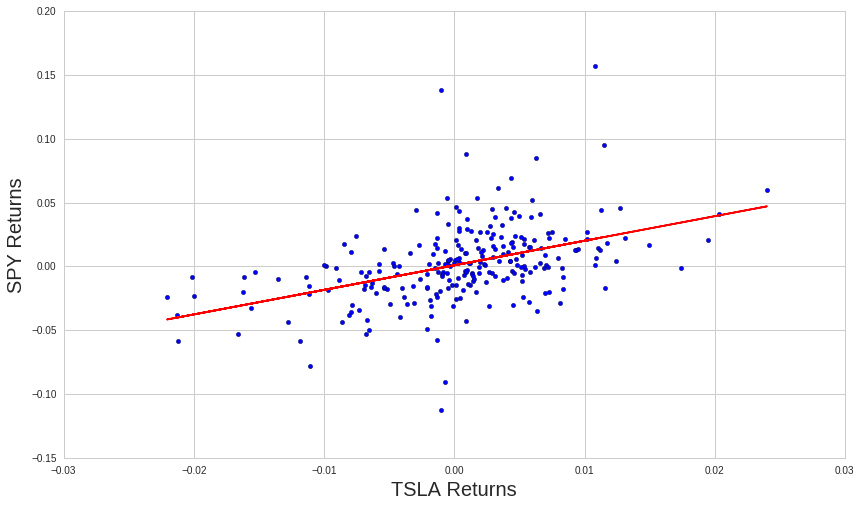

In [51]:
start = '2014-01-01'
end = '2015-01-01'
asset = get_pricing('TSLA', fields='price', start_date=start, end_date=end)
benchmark = get_pricing('SPY', fields='price', start_date=start, end_date=end)

# We have to take the percent changes to get to returns
# Get rid of the first (0th) element because it is NAN
r_a = asset.pct_change()[1:].values
r_b = benchmark.pct_change()[1:].values

# Regressing the benchmark b and asset a
r_b = sm.add_constant(r_b)
model = regression.linear_model.OLS(r_a, r_b).fit()
r_b = r_b[:, 1]

# Coefficients produced by regression
B0 = model.params[0]
B1 = model.params[1]

# Plotting the regression
A_hat = (B1*r_b + B0)
plt.scatter(r_b, r_a, alpha=1) # Plot the raw data
plt.plot(r_b, A_hat, 'r', alpha=1);  # Add the regression line, colored in red
plt.xlabel('TSLA Returns', fontsize = 20)
plt.ylabel('SPY Returns', fontsize = 20)

# Print our result
print "Estimated TSLA Beta:", B1

# Calculating the residuals
residuals = r_a - A_hat

Our regression yielded an estimated market beta of 1.9253; according to the regression, for every 1% in return we see from the SPY, we should see 1.92% from TSLA.

Now that we have the regression results and residuals, we can conduct our residual analysis. Our first step will be to plot the residuals and look for any red flags:

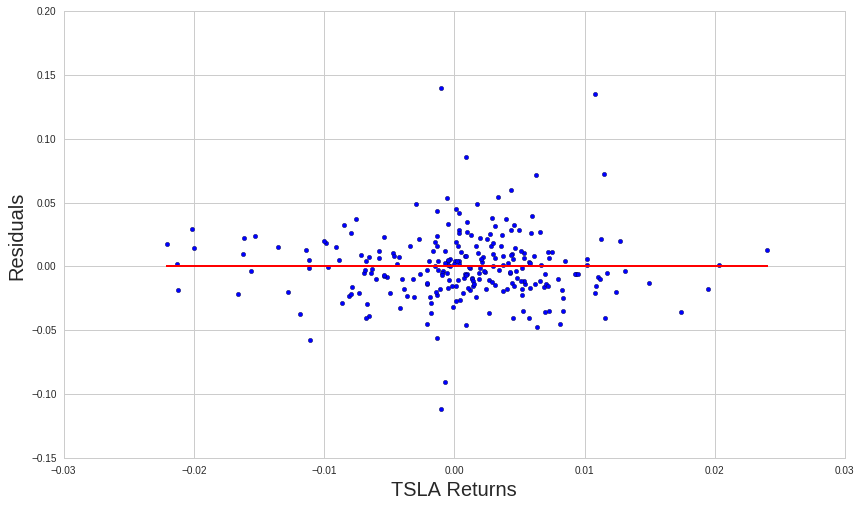

In [372]:
plt.scatter(r_b, residuals);
plt.plot(r_b, r_b*0, color = 'Red');
plt.xlabel('TSLA Returns', fontsize = 20);
plt.ylabel('Residuals', fontsize = 20);

By simply observing the distribution of residuals, it does not seem as if there are any abnormalities. The distribution is relatively random and no patterns can be observed (the clustering around the origin is a result of the nature of returns to cluster around 0 and is not a red flag). Our qualitative conclusion is that the data is homoscedastic and not autocorrelated and therefore satisfies the assumptions for linear regression.

###Breusch-Pagan Heteroscedasticity Test

Our qualitative assessment of the residual plot is nicely supplemented with a couple statistical tests. Let's begin by testing for heteroscedasticity using a Breusch-Pagan test. Using the `het_breuschpagan` function from the statsmodels package:

In [69]:
bp_test = smd.het_breushpagan(model.resid, model.model.exog)

print "Lagrange Multiplier Statistic:", bp_test[0]
print "P-value:", bp_test[1]
print "f-value:", bp_test[2]
print "f_p-value:", bp_test[3], "\n"
if bp_test[1] > 0.05:
    print "The relationship is not heteroscedastic."
if bp_test[1] < 0.05:
    print "The relationship is heteroscedastic."

Lagrange Multiplier Statistic: 0.669337376498
P-value: 0.413282723143
f-value: 0.665779433495
f_p-value: 0.415306831916 

The relationship is not heteroscedastic.


Because the P-value is greater than 0.05, we do not have enough evidence to reject the null hypothesis that the relationship is homoscedastic. This result matches up with our qualitative conclusion.

###Ljung-Box Autocorrelation Test

Let's also check for autocorrelation quantitatively using a Ljung-Box test. Using the `acorr_ljungbox` function from the statsmodels package and the default maximum lag:

In [73]:
lb = smd.acorr_ljungbox(r_a)
print "P-Values:", lb[1], "\n"
if all(lb[1] > 0.05):
    print "The relationship is not autocorrelated."
if any(lb[1] < 0.05):
    print "The relationship is autocorrelated."

P-Values: [ 0.8846583   0.88950844  0.96229443  0.96341497  0.91599599  0.93032135
  0.9643816   0.97852899  0.98390172  0.98786945  0.99167638  0.97134708
  0.91203802  0.9216252   0.94242703  0.87812148  0.90007513  0.92664875
  0.94471082  0.88594594  0.88744682  0.91583141  0.8960177   0.92045423
  0.87780239  0.89866989  0.91536025  0.93228388  0.93825939  0.95373621
  0.91155827  0.9313345   0.94201011  0.94355971  0.94414366  0.95678029
  0.96694651  0.96684993  0.95284072  0.96254994] 

The relationship is not autocorrelated.


Because the Ljung-Box test yielded p-values above 0.05 for all lags, we can conclude that the relationship is not autocorrelated. This result matches up with our qualitative conclusion.

After having visually assessed the residual plot of the regression and then backing it up using statistical tests, we can conclude that the data satisfies the main assumptions and the linear model is valid.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*